In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows',50)
pd.set_option('display.max_columns',50)
pd.set_option('display.width',100)

In [2]:
df = pd.read_csv(r'C:\Users\yezhu\dsi\team_project\data\raw\new_retail_data.csv')
# Select columns I need
df = df[['Transaction_ID','Customer_ID','City', 'State','Country', 'Age', 'Gender', 'Income',
       'Customer_Segment', 'Date', 'Year', 'Month', 'Time', 'Total_Purchases',
       'Amount', 'Total_Amount', 'Product_Category', 'Product_Brand',
       'Product_Type', 'Feedback', 'Shipping_Method', 'Payment_Method',
       'Order_Status', 'Ratings', 'products']]
df.shape

(302010, 25)

In [4]:
# Drop null rows
df_cleaned = df.dropna()
df_cleaned.shape

(295617, 25)

In [5]:
# Data type conversions
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'], format='%m/%d/%Y')
# Create a new column to store yearmonth as integer
#df_cleaned['yearmonth'] = df_cleaned['Date'].dt.strftime('%Y%m').astype(int)
df_cleaned

,Transaction_ID,Customer_ID,City,State,Country,Age,Gender,Income,Customer_Segment,Date,Year,Month,Time,Total_Purchases,Amount,Total_Amount,Product_Category,Product_Brand,Product_Type,Feedback,Shipping_Method,Payment_Method,Order_Status,Ratings,products
0,8691788.0,37249.0,Dortmund,Berlin,Germany,21.0,Male,Low,Regular,2023-09-18,2023.0,September,22:03:55,3.0,108.028757,324.086270,Clothing,Nike,Shorts,Excellent,Same-Day,Debit Card,Shipped,5.0,Cycling shorts
1,2174773.0,69749.0,Nottingham,England,UK,19.0,Female,Low,Premium,2023-12-31,2023.0,December,8:42:04,2.0,403.353907,806.707815,Electronics,Samsung,Tablet,Excellent,Standard,Credit Card,Processing,4.0,Lenovo Tab
2,6679610.0,30192.0,Geelong,New South Wales,Australia,48.0,Male,Low,Regular,2023-04-26,2023.0,April,4:06:29,3.0,354.477600,1063.432799,Books,Penguin Books,Children's,Average,Same-Day,Credit Card,Processing,2.0,Sports equipment
3,7232460.0,62101.0,Edmonton,Ontario,Canada,56.0,Male,High,Premium,2023-05-08,2023.0,May,14:55:17,7.0,352.407717,2466.854021,Home Decor,Home Depot,Tools,Excellent,Standard,PayPal,Processing,4.0,Utility knife
4,4983775.0,27901.0,Bristol,England,UK,22.0,Male,Low,Premium,2024-01-10,2024.0,January,16:54:07,2.0,124.276524,248.553049,Grocery,Nestle,Chocolate,Bad,Standard,Cash,Shipped,1.0,Chocolate cookies
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302005,4246475.0,12104.0,Townsville,New South Wales,Australia,31.0,Male,Medium,Regular,2024-01-20,2024.0,January,23:40:29,5.0,194.792597,973.962984,Books,Penguin Books,Fiction,Bad,Same-Day,Cash,Processing,1.0,Historical fiction
302006,1197603.0,69772.0,Hanover,Berlin,Germany,35.0,Female,Low,New,2023-12-28,2023.0,December,2:55:45,1.0,285.137301,285.137301,Electronics,Apple,Laptop,Excellent,Same-Day,Cash,Processing,5.0,LG Gram
302007,7743242.0,28449.0,Brighton,England,UK,41.0,Male,Low,Premium,2024-02-27,2024.0,February,2:43:49,3.0,60.701761,182.105285,Clothing,Adidas,Jacket,Average,Express,Cash,Shipped,2.0,Parka
302008,9301950.0,45477.0,Halifax,Ontario,Canada,41.0,Male,Medium,New,2023-09-03,2023.0,September,11:20:31,1.0,120.834784,120.834784,Home Decor,IKEA,Furniture,Good,Standard,Cash,Shipped,4.0,TV stand


In [6]:
# Extract year and month for further analysis
df_cleaned['year'] = df_cleaned['Date'].dt.year
df_cleaned['month'] = df_cleaned['Date'].dt.month

# Aggregate transaction value by month
monthly_data = df_cleaned.groupby(['year', 'month'])['Total_Amount'].sum().reset_index()

# Create a 'date' column for easier plotting
monthly_data['date'] = pd.to_datetime(monthly_data[['year', 'month']].assign(day=1))

In [7]:
df_cleaned.columns

Index(['Transaction_ID', 'Customer_ID', 'City', 'State', 'Country', 'Age', 'Gender', 'Income',
       'Customer_Segment', 'Date', 'Year', 'Month', 'Time', 'Total_Purchases', 'Amount',
       'Total_Amount', 'Product_Category', 'Product_Brand', 'Product_Type', 'Feedback',
       'Shipping_Method', 'Payment_Method', 'Order_Status', 'Ratings', 'products', 'year',
       'month'],
      dtype='object')

In [12]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Feature selection: Select relevant features for clustering
features = df_cleaned[['Age', 'Gender', 'Income', 'Total_Purchases',  'Total_Amount']]

# Convert 'Income' into numerical format
label_encoder = LabelEncoder()
features['Income'] = label_encoder.fit_transform(features['Income'])  # low=0, medium=1, high=2

# Convert 'Gender' into numerical format
features = pd.get_dummies(features, columns=['Gender'], drop_first=True)  # Male=1, Female=0

# Handle missing values (if any)
features = features.dropna()

# Scaling the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)



In [21]:
# Elbow method to find the optimal number of clusters
sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

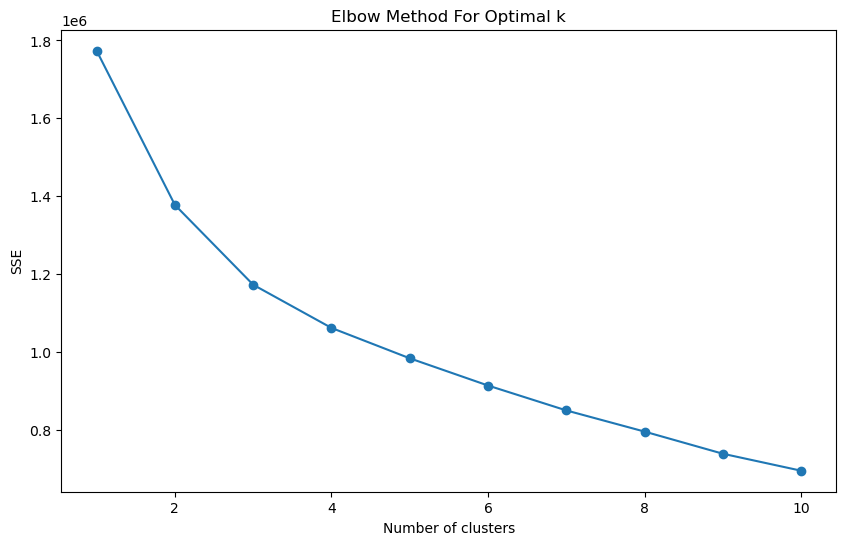

In [22]:
# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()


In [ ]:
# Apply K-Means with the selected number of clusters
optimal_clusters = 4  
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

In [36]:
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# Run K-Means again
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(pca_features)
silhouette_avg = silhouette_score(pca_features, clusters)
print("Silhouette Score after PCA: ", silhouette_avg)

Silhouette Score after PCA:  0.3616475103508328


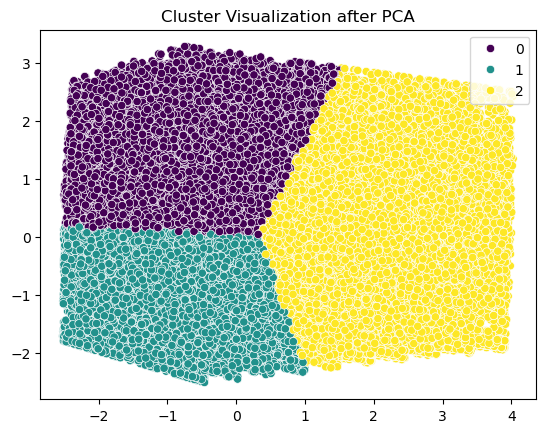

In [38]:
# Visualize clusters after PCA or other dimensionality reduction
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=clusters, palette='viridis')
plt.title('Cluster Visualization after PCA')
plt.show()